## Import Modules

In [33]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
import seaborn as sns

import matplotlib.pyplot as plt

from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPooling2D,AvgPool2D,GlobalAveragePooling2D,Dense,Dropout,BatchNormalization,Flatten,Input
from sklearn.model_selection import train_test_split


from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import load_img


## Load the Dataset

In [34]:
BASE_DIR = 'UTKFace'

In [35]:
#display a progress bar 
from tqdm import tqdm
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []
#extracts the age and gender information from the filenames 
# exp :name file :  26_0_3_20170104214719799.jpg
for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0]) # age : 26
    gender = int(temp[1]) # gender : 0 (male)
    image_paths.append(image_path) 
    age_labels.append(age)
    gender_labels.append(gender)

100%|████████████████████████████████████████████████████████████████████████| 23708/23708 [00:00<00:00, 213328.41it/s]


In [36]:
# convert to dataframe : combines lists  into a structured format using a DataFrame
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

image  age  gender
0  UTKFace\100_0_0_20170112213500903.jpg.chip.jpg  100       0
1  UTKFace\100_0_0_20170112215240346.jpg.chip.jpg  100       0
2  UTKFace\100_1_0_20170110183726390.jpg.chip.jpg  100       1
3  UTKFace\100_1_0_20170112213001988.jpg.chip.jpg  100       1
4  UTKFace\100_1_0_20170112213303693.jpg.chip.jpg  100       1

In [37]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

## Exploratory Data Analysis

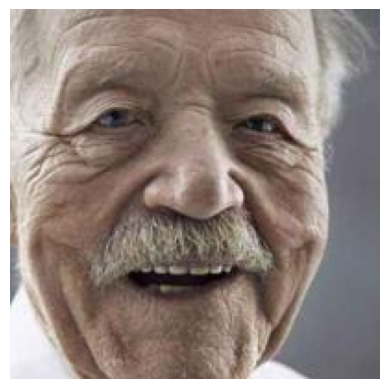

In [38]:
from PIL import Image 

img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

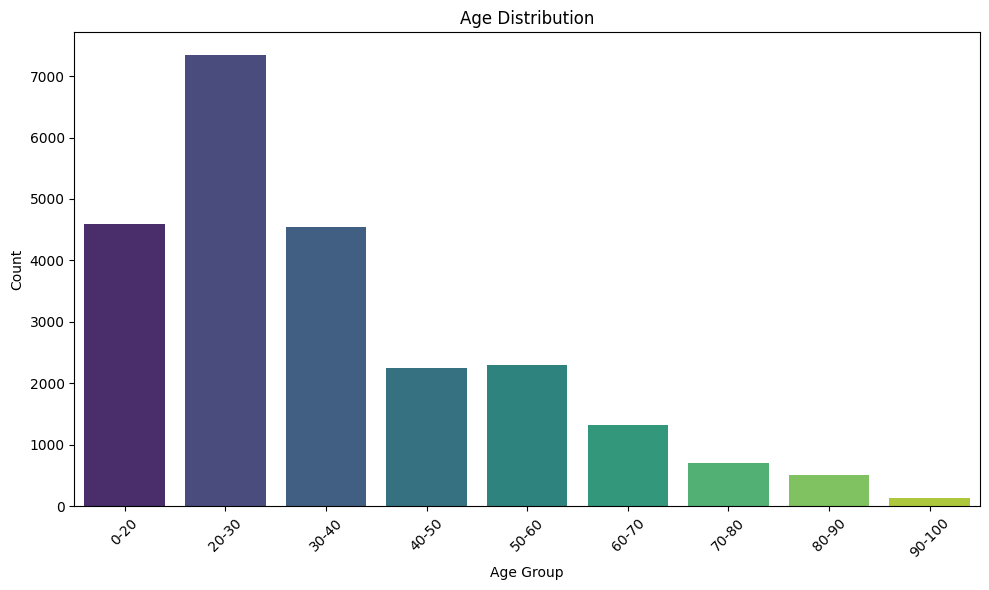

In [39]:
# create informative statistical graphics
# visualize the number of occurrences for each category in a categorical variable.
# Creating age groups
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# Creating the count plot
plt.figure(figsize=(10, 6))
sns.countplot(x='age_group', hue='age_group', data=df, palette='viridis', legend=False)
plt.title('Age Distribution')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


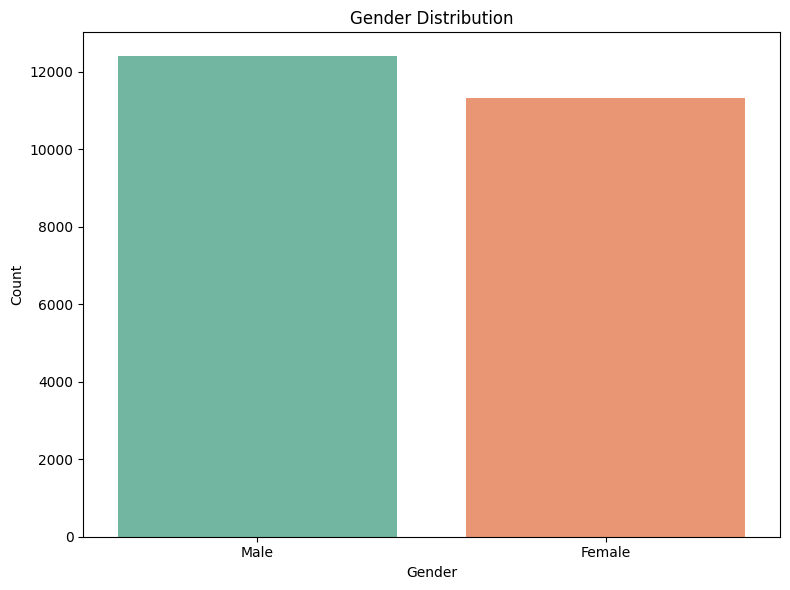

In [40]:

#bar plot to visualize the distribution of gender
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', hue='gender', data=df, palette='Set2', legend=False)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Male', 'Female'])
plt.tight_layout()
plt.show()



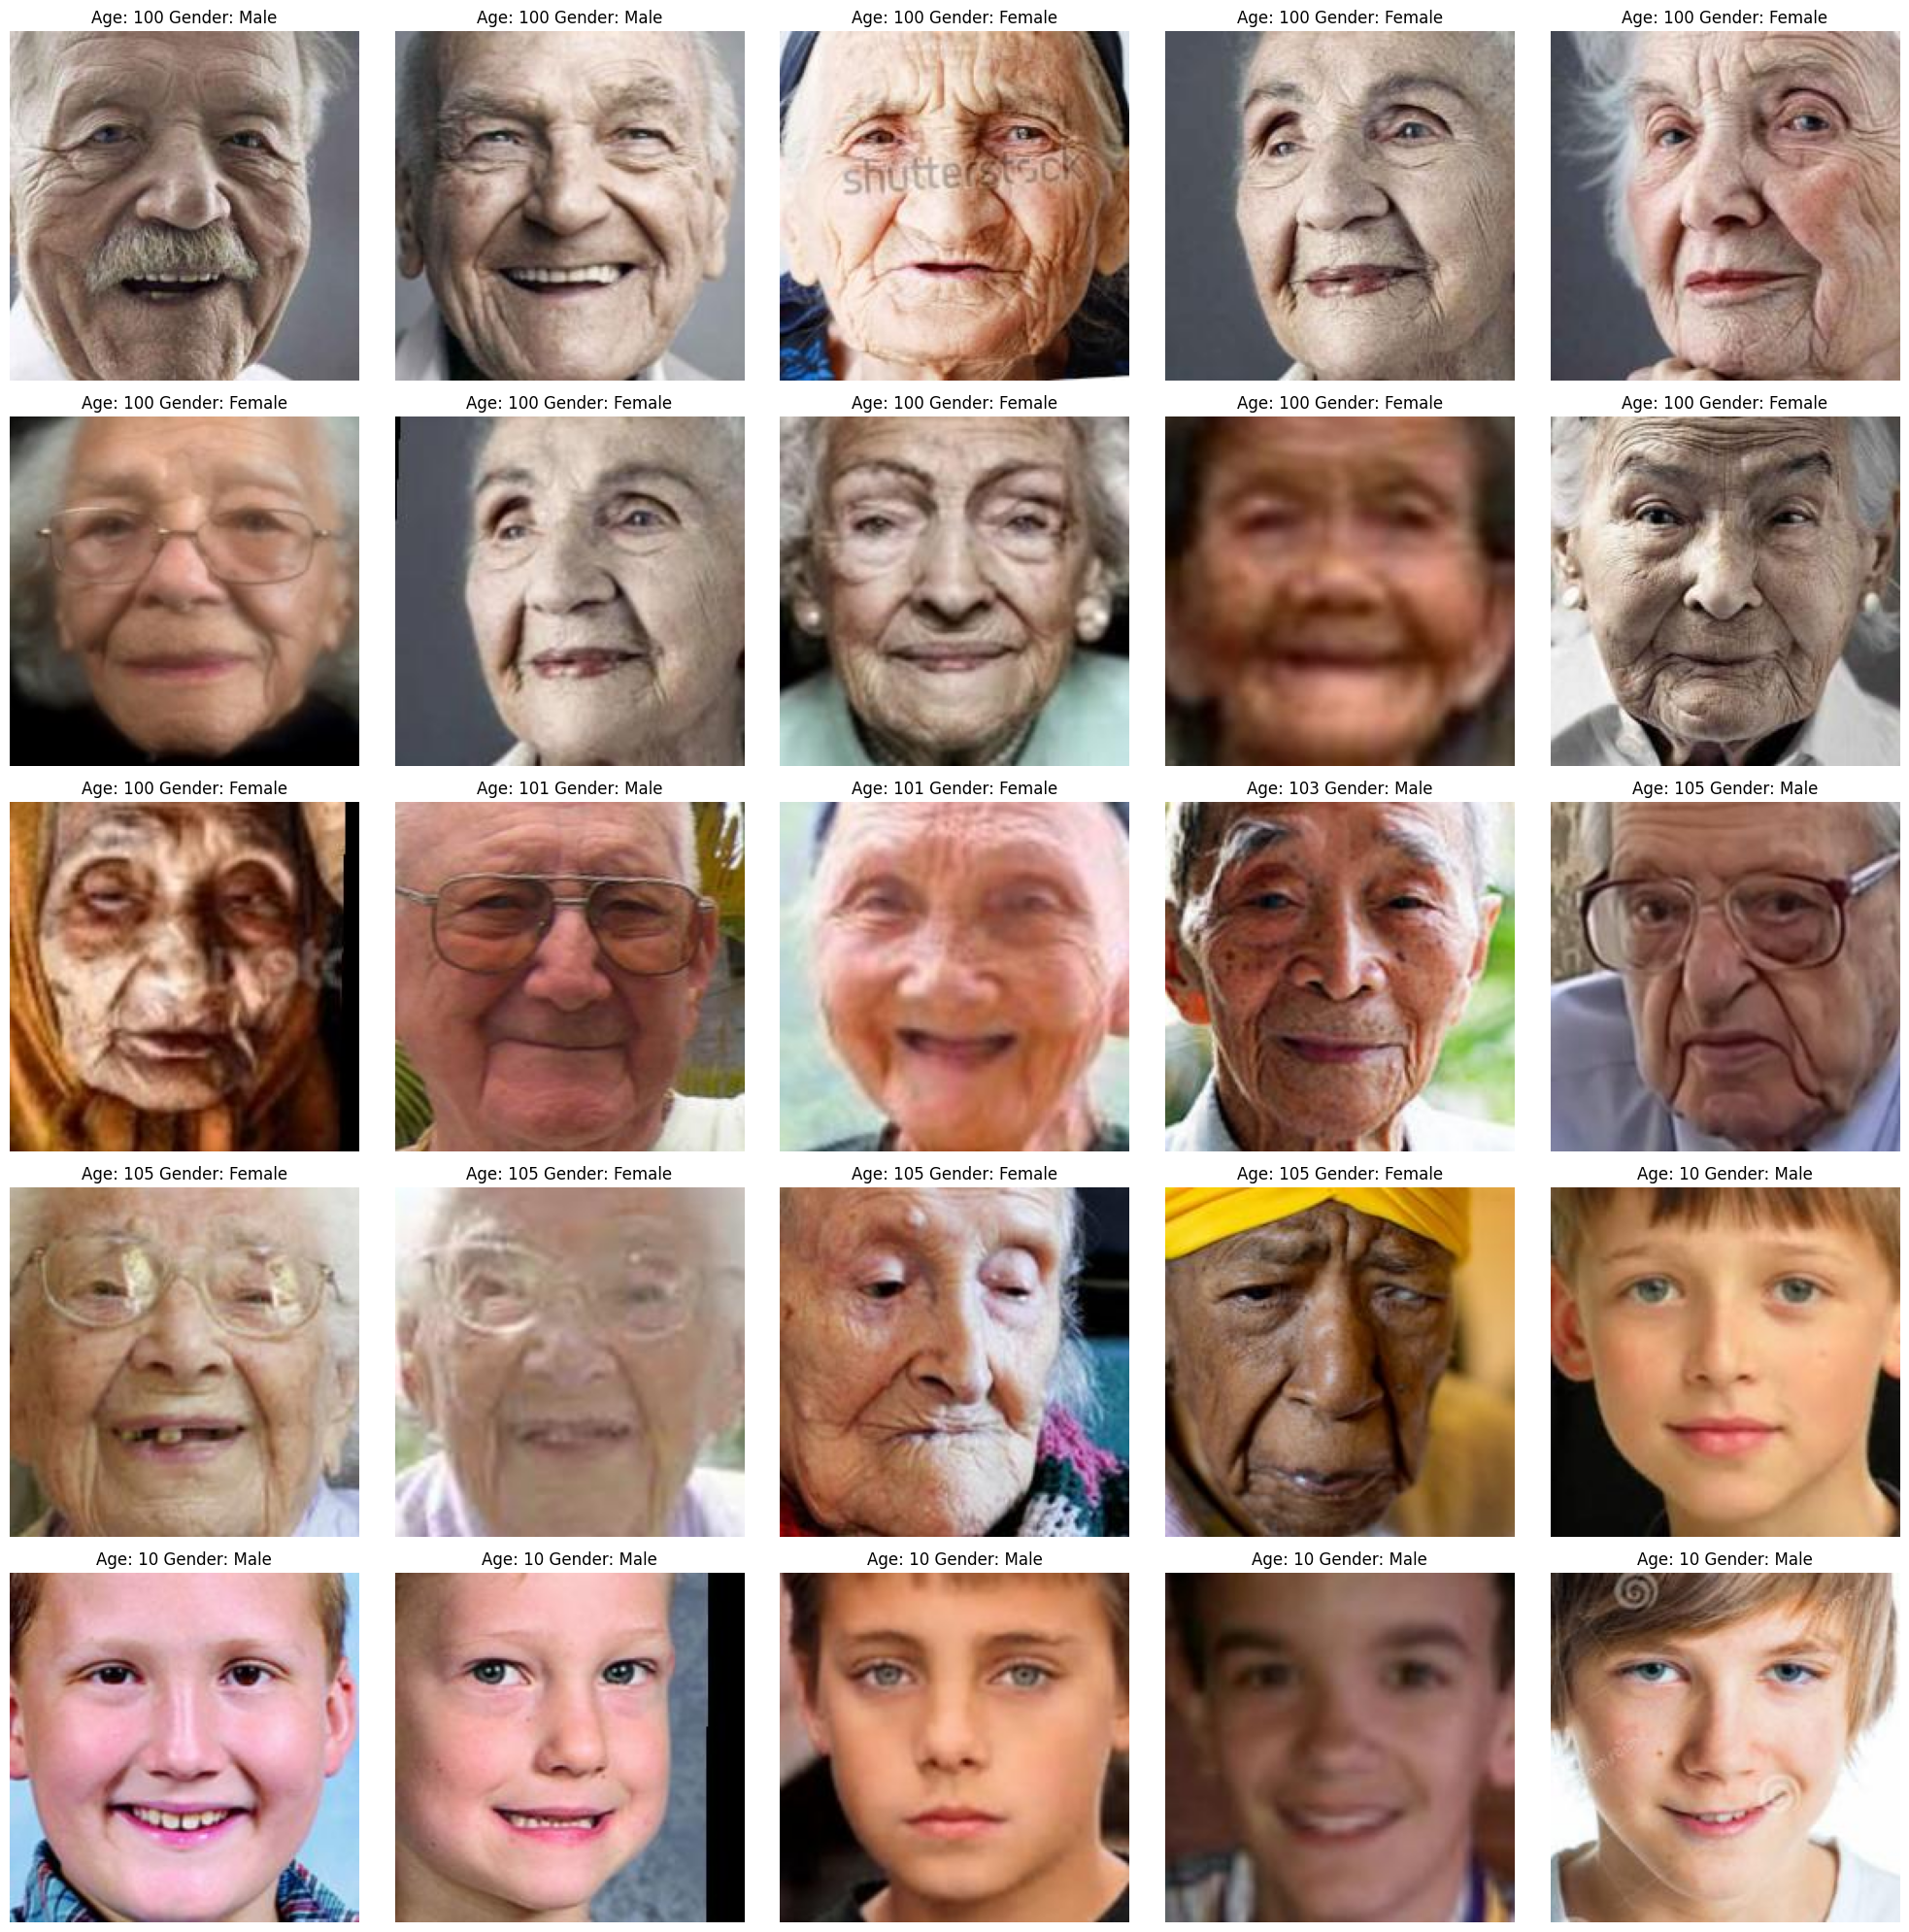

In [41]:
# to display grid of images

# Assuming you have defined gender_dict somewhere
gender_dict = {0: 'Male', 1: 'Female'}

plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, row in files.iterrows():
    file = row['image']
    age = row['age']
    gender = row['gender']
    
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


<Figure size 800x600 with 0 Axes>

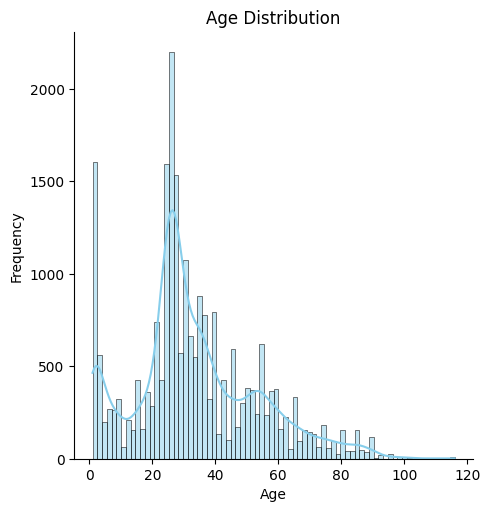

In [42]:
# Create a histogram of the 'age' column
#Distplot of the age attribute
#The majority are in between ages 20 to 40 years old.
plt.figure(figsize=(8, 6))
sns.displot(df['age'], kde=True, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

## Feature Extraction

In [43]:
# Feature Extraction refers to the process of transforming raw data, such as images into a format that is suitable for analysis and modeling.
# resize the pictures 128 *128 px --> standarisation 
from keras.preprocessing.image import load_img
import numpy as np
from PIL import Image

# thiq function resizes images to a fixed size, converting them to grayscale, and converting them into a numerical format 
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), resample=Image.LANCZOS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # 1 -->  grayscale image : which corresponds to the intensity of brightness.
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [44]:
X = extract_features(df['image'])


100%|███████████████████████████████████████████████████████████████████████████| 23708/23708 [02:05<00:00, 188.93it/s]


In [45]:
X.shape

(23708, 128, 128, 1)

In [46]:
# normalize the images
# dividing each pixel value by 255 scales them to the range between 0 and 1.
# max value of pixel is 255
X = X/255.0

In [47]:
input_shape = (128, 128, 1)

## Model Creation

In [48]:
inputs = Input((input_shape))
# convolutional layers
#Conv2D:  convolutional layer in Keras used for 2D spatial convolution over images.
# paramethre 32 : filters applied to the input image.
# filters  learn to detect  features like edges, corners, or textures.
# the resulting feature maps are passed through activation functions (ReLU)
# convolution operation will be applied using a 3x3 filter
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

#Flattening Layer
flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)
#Output Layers:
output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

#Model Compilation
model = Model(inputs=[inputs], outputs=[output_1, output_2])
#loss functions: Since the model has two outputs , we have two loss functions. 
#The first loss function :'binary_crossentropy', is used for binary classification tasks like gender prediction.
#The second loss function :'mae', stands for Mean Absolute Error, which is often used for regression tasks like age prediction.
#optimizer='adam': This specifies the optimization algorithm to be used (adam).
model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

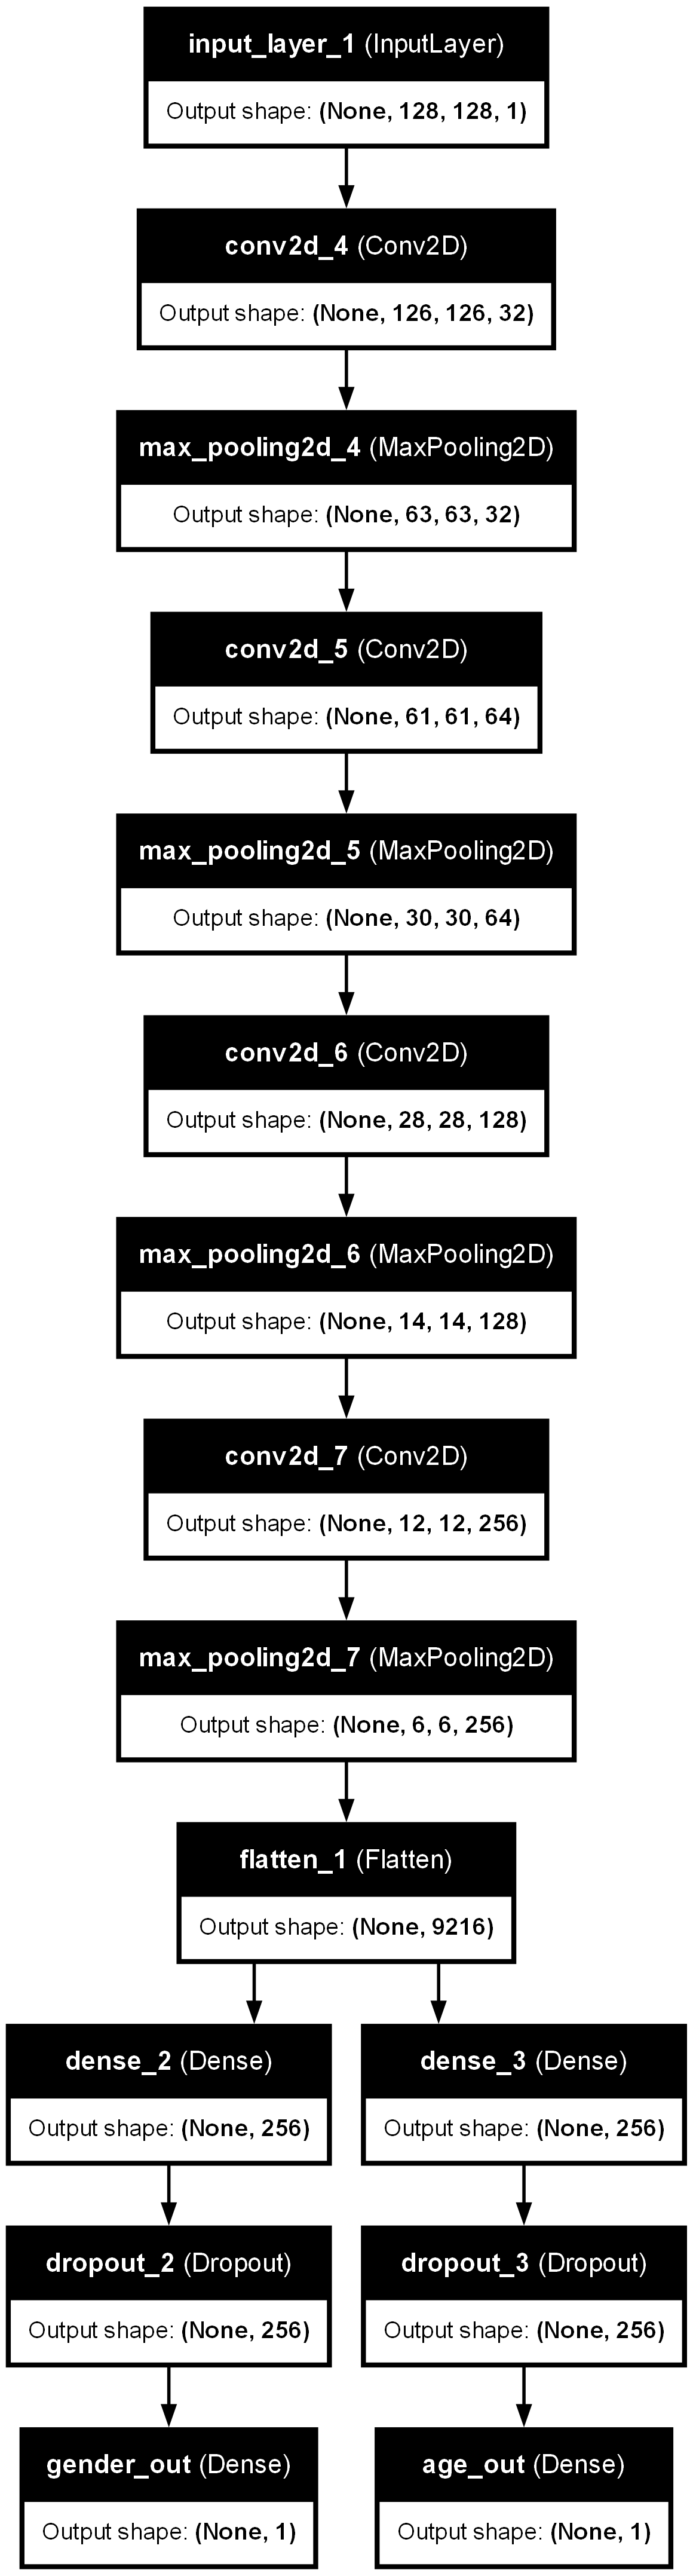

In [49]:
# plot the model
#visualize your model's architecture
import pydot
import os
os.environ["PATH"] += os.pathsep +'C:/Program Files/Graphviz/bin/'
from tensorflow.keras.utils import plot_model
# The plot_model function is used to visualize the architecture
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


# the output shape indicates that the Conv2D layer has produced a batch of feature maps with a height and width of 126 pixels each, using 32 filters.


In [50]:
## train model

In [51]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

# Select the first 1000 images and their corresponding labels
X_subset = X[:1000]
y_gender_subset = y_gender[:1000]
y_age_subset = y_age[:1000]

# Compile the model  
model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

# Train model on the subset of data
history = model.fit(x=X_subset, y=[y_gender_subset, y_age_subset], batch_size=32, epochs=30, validation_split=0.2)




Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 480ms/step - age_out_mae: 8.3967 - gender_out_accuracy: 0.5133 - loss: 9.2483 - val_age_out_mae: 3.9235 - val_gender_out_accuracy: 0.6550 - val_loss: 4.6226
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 446ms/step - age_out_mae: 5.7249 - gender_out_accuracy: 0.5227 - loss: 6.4336 - val_age_out_mae: 4.4871 - val_gender_out_accuracy: 0.4100 - val_loss: 5.1983
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 449ms/step - age_out_mae: 6.6901 - gender_out_accuracy: 0.5223 - loss: 7.3842 - val_age_out_mae: 3.3916 - val_gender_out_accuracy: 0.3700 - val_loss: 4.1025
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 449ms/step - age_out_mae: 6.2013 - gender_out_accuracy: 0.4992 - loss: 6.8966 - val_age_out_mae: 5.0367 - val_gender_out_accuracy: 0.3450 - val_loss: 5.7596
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 446ms/step - age_out_mae: 5.4092 - gender_out_accuracy: 0.5178 - loss: 6.1009 - val_age_out_mae: 2.4816 - val_gender_out_accuracy: 0.3450 - val_loss: 3.2111
Epoch

## Plot the Results

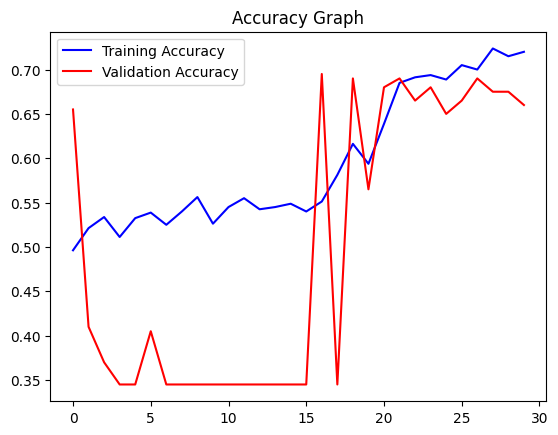

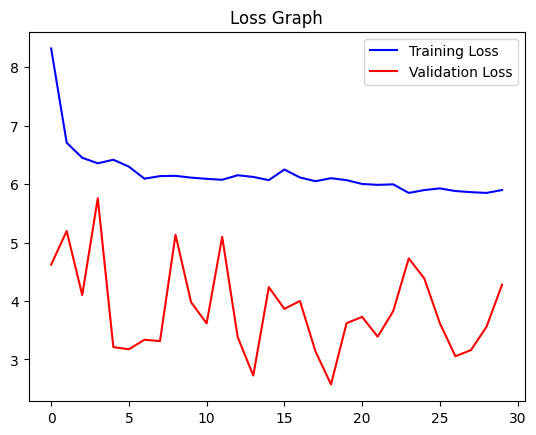

In [52]:
# Plot results for gender
acc = history.history['gender_out_accuracy']  # Get training accuracy for gender output
val_acc = history.history['val_gender_out_accuracy']  # Get validation accuracy for gender output
epochs = range(len(acc))  # Get number of epochs

plt.plot(epochs, acc, 'b', label='Training Accuracy')  # Plot training accuracy curve in blue
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')  # Plot validation accuracy curve in red
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']  # Get training loss for the entire model
val_loss = history.history['val_loss']  # Get validation loss for the entire model

plt.plot(epochs, loss, 'b', label='Training Loss')  # Plot training loss curve in blue
plt.plot(epochs, val_loss, 'r', label='Validation Loss')  # Plot validation loss curve in red
plt.title('Loss Graph')  # Set title of the plot
plt.legend()  # Show legend
plt.show()  # Show the plot




# Prediction with Test Data

Original Gender: Male Original Age: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Predicted Gender: Female Predicted Age: 12


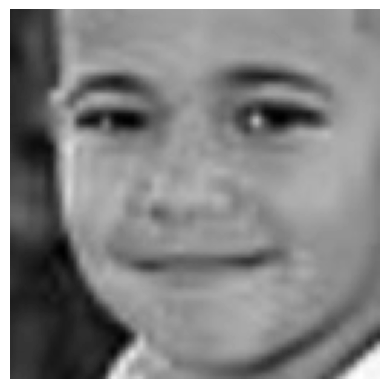

In [53]:
image_index = 90
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted Gender: Male Predicted Age: 13


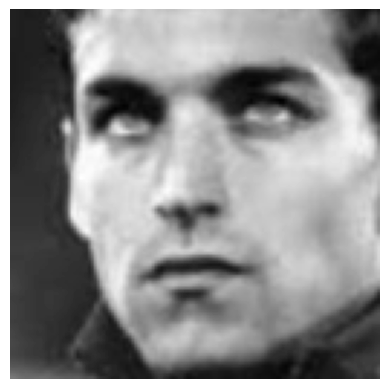

In [54]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Gender: Female Predicted Age: 14


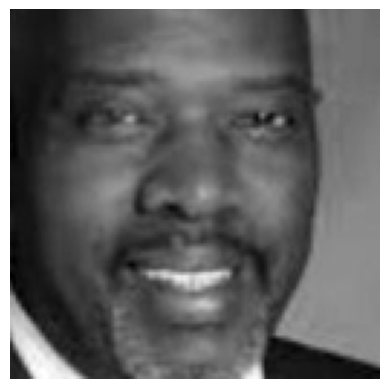

In [55]:
image_index = 19000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

In [56]:
from tensorflow.keras.models import load_model
model.save('age_model.keras')
keras.models.load_model("age_model.keras")



<Functional name=functional_3, built=True>